### Comparing Models and Vectorization Strategies for Text Classification

This try-it focuses on weighing the positives and negatives of different estimators and vectorization strategies for a text classification problem.  In order to consider each of these components, you should make use of the `Pipeline` and `GridSearchCV` objects in scikitlearn to try different combinations of vectorizers with different estimators.  For each of these, you also want to use the `.cv_results_` to examine the time for the estimator to fit the data.

### The Data

The dataset below is from [kaggle](https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection) and contains a dataset named the "ColBert Dataset" created for this [paper](https://arxiv.org/pdf/2004.12765.pdf).  You are to use the text column to classify whether or not the text was humorous.  It is loaded and displayed below.

**Note:** The original dataset contains 200K rows of data. It is best to try to use the full dtaset. If the original dataset is too large for your computer, please use the 'dataset-minimal.csv', which has been reduced to 100K.

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('../text_data/dataset.csv')

In [5]:
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


#### Task


**Text preprocessing:** As a pre-processing step, perform both `stemming` and `lemmatizing` to normalize your text before classifying. For each technique use both the `CountVectorize`r and `TfidifVectorizer` and use options for stop words and max features to prepare the text data for your estimator.

**Classification:** Once you have prepared the text data with stemming lemmatizing techniques, consider `LogisticRegression`, `DecisionTreeClassifier`, and `MultinomialNB` as classification algorithms for the data. Compare their performance in terms of accuracy and speed.

Share the results of your best classifier in the form of a table with the best version of each estimator, a dictionary of the best parameters and the best score.

In [7]:
pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes'], 
             'best_params': ['', '', ''],
             'best_score': ['', '', '']}).set_index('model')

,best_params,best_score
model,,
Logistic,,
Decision Tree,,
Bayes,,


### Setting Up the Environment and Importing Necessary Libraries

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import nltk
import time

# Download NLTK data if needed
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mitalibansal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Preprocessing

In [11]:
# Text preprocessing functions
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

def lemmatizing(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Prepare a FunctionTransformer for both stemming and lemmatizing
stem_transformer = FunctionTransformer(lambda x: x.apply(stemming))
lemmatize_transformer = FunctionTransformer(lambda x: x.apply(lemmatizing))

# Prepare vectorizers
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

### Train / Test Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = df['text']
y = df['humor']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Creating Pipelines and Grid Search

In [17]:
# Prepare classifiers
logistic = LogisticRegression(max_iter=1000)
decision_tree = DecisionTreeClassifier()
bayes = MultinomialNB()

# Define pipelines
pipelines = [
    ('logistic_stem_count', Pipeline([
        ('stem', stem_transformer),
        ('vectorize', count_vectorizer),
        ('classify', logistic)
    ])),
    ('logistic_stem_tfidf', Pipeline([
        ('stem', stem_transformer),
        ('vectorize', tfidf_vectorizer),
        ('classify', logistic)
    ])),
    ('logistic_lemmatize_count', Pipeline([
        ('lemmatize', lemmatize_transformer),
        ('vectorize', count_vectorizer),
        ('classify', logistic)
    ])),
    ('logistic_lemmatize_tfidf', Pipeline([
        ('lemmatize', lemmatize_transformer),
        ('vectorize', tfidf_vectorizer),
        ('classify', logistic)
    ])),
    ('tree_stem_count', Pipeline([
        ('stem', stem_transformer),
        ('vectorize', count_vectorizer),
        ('classify', decision_tree)
    ])),
    ('tree_stem_tfidf', Pipeline([
        ('stem', stem_transformer),
        ('vectorize', tfidf_vectorizer),
        ('classify', decision_tree)
    ])),
    ('tree_lemmatize_count', Pipeline([
        ('lemmatize', lemmatize_transformer),
        ('vectorize', count_vectorizer),
        ('classify', decision_tree)
    ])),
    ('tree_lemmatize_tfidf', Pipeline([
        ('lemmatize', lemmatize_transformer),
        ('vectorize', tfidf_vectorizer),
        ('classify', decision_tree)
    ])),
    ('bayes_stem_count', Pipeline([
        ('stem', stem_transformer),
        ('vectorize', count_vectorizer),
        ('classify', bayes)
    ])),
    ('bayes_stem_tfidf', Pipeline([
        ('stem', stem_transformer),
        ('vectorize', tfidf_vectorizer),
        ('classify', bayes)
    ])),
    ('bayes_lemmatize_count', Pipeline([
        ('lemmatize', lemmatize_transformer),
        ('vectorize', count_vectorizer),
        ('classify', bayes)
    ])),
    ('bayes_lemmatize_tfidf', Pipeline([
        ('lemmatize', lemmatize_transformer),
        ('vectorize', tfidf_vectorizer),
        ('classify', bayes)
    ]))
]

In [18]:
# Perform GridSearchCV for each pipeline
results = []

for name, pipeline in pipelines:
    # Define parameter grid based on classifier
    param_grid = {'classify__C': [0.1, 1, 10]} if 'logistic' in name else \
                 {'classify__max_depth': [None, 10, 20]} if 'tree' in name else \
                 {'classify__alpha': [0.01, 0.1, 1.0]}

    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3, verbose=1)
    
    start_time = time.time()
    grid.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    y_pred = grid.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    y_prob = grid.predict_proba(X_test)[:, 1]  # Probability of the positive class
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'fit_time': elapsed_time,
        'test_score': acc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'AUC': auc,
        'y pred': y_pred,
        'y_prob': y_prob
    })
    print(name, grid.best_params_, grid.best_score_, acc_score, elapsed_time)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
logistic_stem_count {'classify__C': 1} 0.88474 0.88952 373.0890119075775
Fitting 3 folds for each of 3 candidates, totalling 9 fits
logistic_stem_tfidf {'classify__C': 10} 0.8844866666666666 0.88906 485.53130173683167
Fitting 3 folds for each of 3 candidates, totalling 9 fits
logistic_lemmatize_count {'classify__C': 1} 0.8805066666666667 0.88286 138.33938312530518
Fitting 3 folds for each of 3 candidates, totalling 9 fits
logistic_lemmatize_tfidf {'classify__C': 10} 0.8802333333333334 0.88286 123.86745977401733
Fitting 3 folds for each of 3 candidates, totalling 9 fits
tree_stem_count {'classify__max_depth': None} 0.8125133333333334 0.81806 573.2026929855347
Fitting 3 folds for each of 3 candidates, totalling 9 fits
tree_stem_tfidf {'classify__max_depth': None} 0.8161933333333332 0.82382 610.4389350414276
Fitting 3 folds for each of 3 candidates, totalling 9 fits
tree_lemmatize_count {'classify__max_depth': None} 0.807273333333

### Creating a DataFrame of Results

In [20]:
# Display the results in a DataFrame
results_df = pd.DataFrame(results)
results_df

,model,best_params,best_score,fit_time,test_score,precision,recall,f1,AUC,y pred,y_prob
0,logistic_stem_count,{'classify__C': 1},0.884740,373.089012,0.88952,0.885977,0.894333,0.890135,0.957618,"[True, False, False, False, False, False, Fals...","[0.7154855155045906, 0.037322759683879526, 0.0..."
1,logistic_stem_tfidf,{'classify__C': 10},0.884487,485.531302,0.88906,0.887316,0.891535,0.889420,0.957524,"[True, False, False, False, False, False, Fals...","[0.8482950613561332, 0.02277640503935288, 0.00..."
2,logistic_lemmatize_count,{'classify__C': 1},0.880507,138.339383,0.88286,0.880394,0.886340,0.883357,0.954370,"[True, False, False, False, False, False, True...","[0.7445246325153857, 0.018519987188501834, 0.0..."
3,logistic_lemmatize_tfidf,{'classify__C': 10},0.880233,123.867460,0.88286,0.882123,0.884062,0.883091,0.953511,"[True, False, False, False, False, False, True...","[0.7960728811161272, 0.005591973294179466, 0.0..."
4,tree_stem_count,{'classify__max_depth': None},0.812513,573.202693,0.81806,0.809741,0.831908,0.820675,0.822298,"[True, False, False, False, False, False, Fals...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
5,tree_stem_tfidf,{'classify__max_depth': None},0.816193,610.438935,0.82382,0.818714,0.832228,0.825416,0.825130,"[False, False, False, False, False, False, Fal...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
6,tree_lemmatize_count,{'classify__max_depth': None},0.807273,271.062934,0.81284,0.807402,0.822117,0.814693,0.823365,"[False, False, False, True, False, False, True...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
7,tree_lemmatize_tfidf,{'classify__max_depth': None},0.813500,325.117755,0.82394,0.817087,0.835145,0.826017,0.825252,"[False, False, False, True, False, False, True...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
8,bayes_stem_count,{'classify__alpha': 0.1},0.877893,365.141807,0.88006,0.877585,0.883582,0.880574,0.953435,"[True, False, False, False, False, False, Fals...","[0.8389362115176086, 0.028648047601821987, 7.4..."
9,bayes_stem_tfidf,{'classify__alpha': 1.0},0.876713,365.176955,0.87936,0.878498,0.880745,0.879620,0.952459,"[True, False, False, False, False, False, Fals...","[0.6999053422022405, 0.19149800717584767, 0.01..."


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

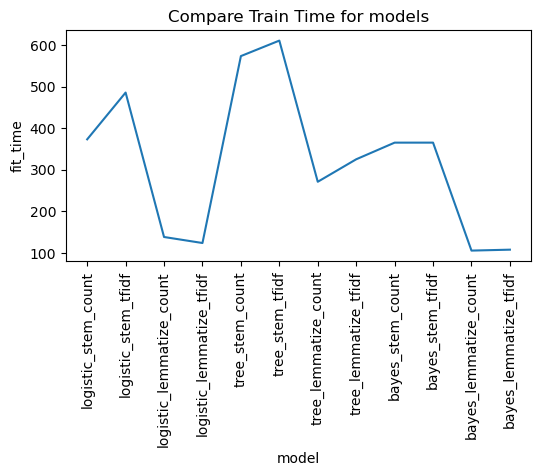

In [22]:
plt.figure(figsize=(6,3))
sns.lineplot(results_df, x='model', y='fit_time')
plt.title('Compare Train Time for models')
plt.xticks(rotation=90)
plt.show()

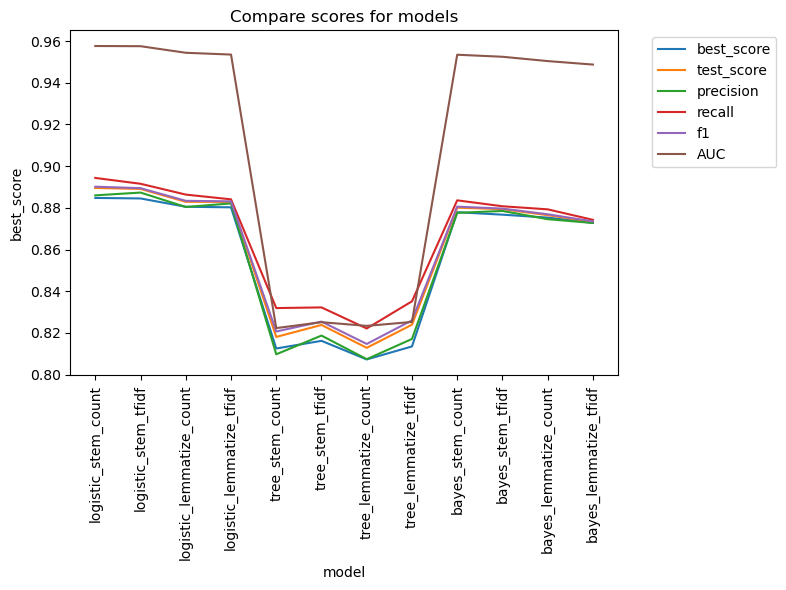

In [23]:
# Define the metrics to plot
metrics = ['best_score', 'test_score', 'precision', 'recall', 'f1', 'AUC']
plt.figure(figsize=(8,6))

# Plot each metric
for metric in metrics:
    sns.lineplot(data=results_df, x='model', y=metric, label=metric)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Compare scores for models')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

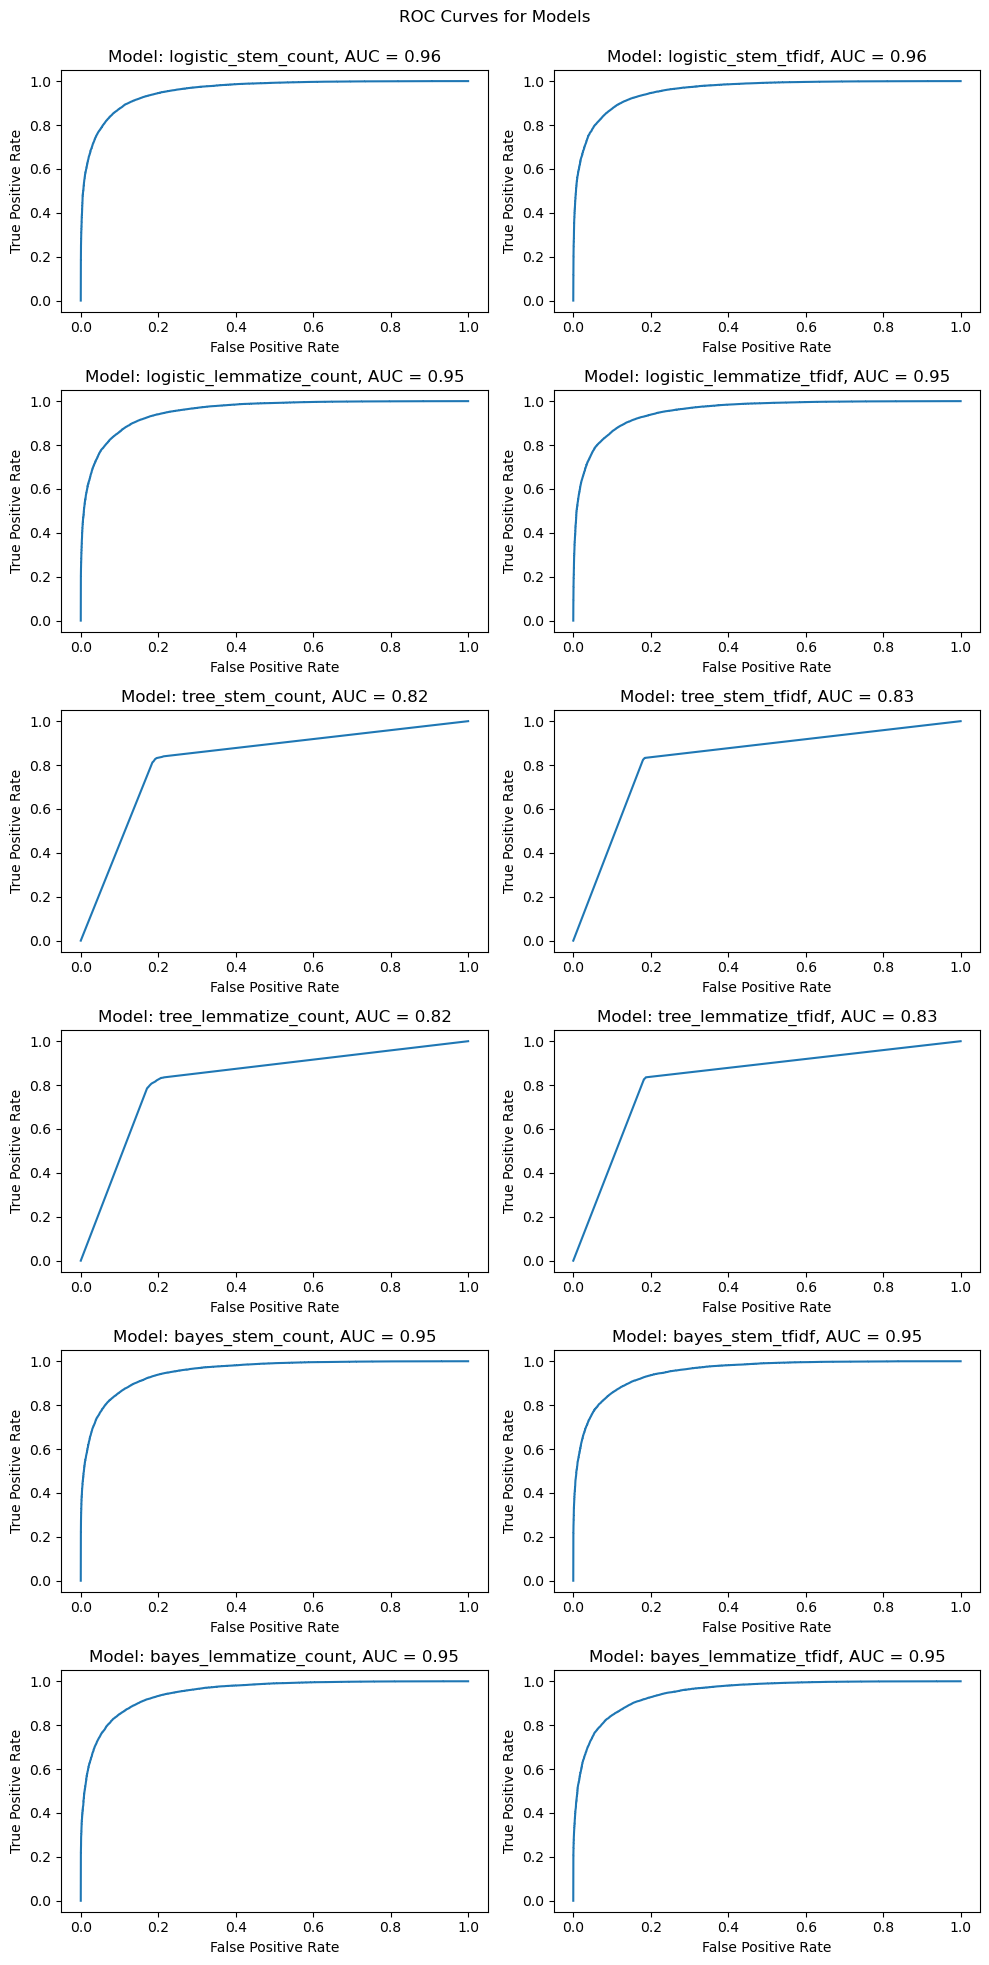

In [24]:
fig, axes = plt.subplots(6, 2, figsize=(10, 20))  
fig.suptitle('ROC Curves for Models\n\n')  # Add a title for the entire figure

# Counter to keep track of subplot position
plot_count = 0

for index, row in results_df.iterrows():
    model = row['model']
    y_prob = row['y_prob']

    # Access current subplot based on counter
    ax = axes.flat[plot_count]  # Flattened array for easier access
    
    # Visualizing ROC Curve

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    ax.plot(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"Model: {model}, AUC = {round(row['AUC'],2)}")

    plot_count += 1

# Adjust layout to prevent overlapping elements (optional)
plt.tight_layout()

plt.show()

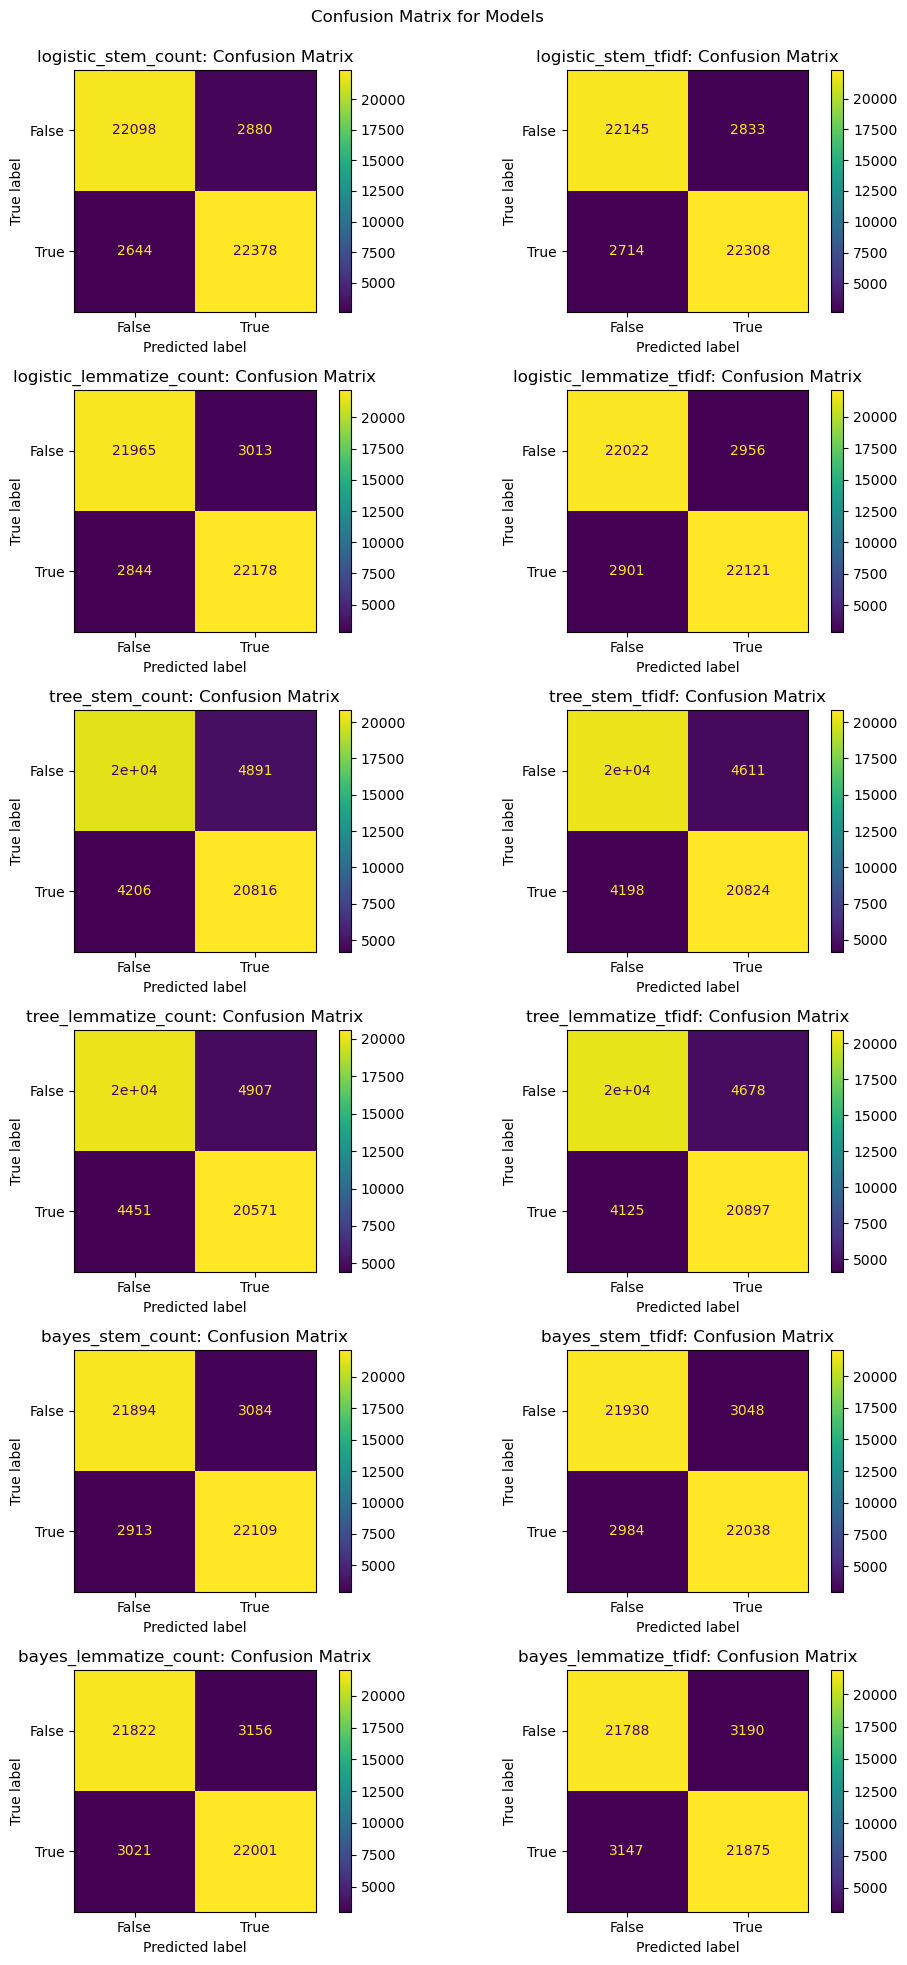

In [25]:
fig, axes = plt.subplots(6, 2, figsize=(10, 20))  
fig.suptitle('Confusion Matrix for Models\n\n')  # Add a title for the entire figure

# Counter to keep track of subplot position
plot_count = 0

for index, row in results_df.iterrows():
    model = row['model']
    y_pred = row['y pred'] 

    # Access current subplot based on counter
    ax = axes.flat[plot_count]  # Flattened array for easier access

    # Visualizing Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    ax.set_title(f"{model}: Confusion Matrix")

    plot_count += 1

# Adjust layout to prevent overlapping elements (optional)
plt.tight_layout()
plt.show()

### Conclusion:

- **Logistic Regression** models consistently outperform the others, especially when using stemming with count vectorization. These models offer the best balance of precision, recall, F1, and AUC, making them well-suited for text classification tasks that require accurate class identification and discrimination. Although stemming slightly improves metrics, it is more computationally expensive compared to lemmatizing.

- **Decision Trees** exhibit strong recall and F1 scores but fall short of logistic regression across all metrics.

- **Naive Bayes** models deliver competitive performance with higher computational costs and lower metrics compared to logistic regression.

Overall, the `logistic_stem_count` model stands out due to its robust performance across all key metrics. However, if computational efficiency is a concern, the `logistic_lemmatize_count` model is a viable alternative.

In [48]:
results_df[['model', 'best_params']]

,model,best_params
0,logistic_stem_count,{'classify__C': 1}
1,logistic_stem_tfidf,{'classify__C': 10}
2,logistic_lemmatize_count,{'classify__C': 1}
3,logistic_lemmatize_tfidf,{'classify__C': 10}
4,tree_stem_count,{'classify__max_depth': None}
5,tree_stem_tfidf,{'classify__max_depth': None}
6,tree_lemmatize_count,{'classify__max_depth': None}
7,tree_lemmatize_tfidf,{'classify__max_depth': None}
8,bayes_stem_count,{'classify__alpha': 0.1}
9,bayes_stem_tfidf,{'classify__alpha': 1.0}
